<a href="https://colab.research.google.com/github/RyC37/Emotional-Status-with-Wearable-Data/blob/master/Predict_Positive_or_Negative_Emotion_for_New_User.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict Positive or Negative Emotion (Fitbit Data + Survey Data, Split by Subject)

Author: Sicong Zhao

In [0]:
import pandas as pd
import numpy as np
!pip install catboost
import catboost
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GroupKFold

# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
# Random Forest
from sklearn.ensemble import RandomForestClassifier

# Evaluation
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, auc, roc_curve, precision_recall_curve
import seaborn as sns

# Re-sample
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

In [0]:
pd.set_option('display.max_rows', 1000)

## 1.Load Data

In [0]:
exp = pd.read_csv('exp_steps_hr_sleep_survey.csv')

## 2.EDA

### (1) Missing Data Detection

In [0]:
missing_rate = exp.isna().sum()/exp.shape[0]
missing_rate

Unnamed: 0                 0.000000
subject                    0.000000
la_p                       0.000324
ha_p                       0.000000
ha_n                       0.000000
la_n                       0.000000
la                         0.000000
p                          0.000000
n                          0.000000
ha                         0.000000
start_survey               0.002595
survey_no                  0.000000
experiment                 0.000000
DATE_x                     0.000000
Period_of_day              0.002595
VALENCE                    0.000324
VALENCE_mean               0.000324
start_survey_5m_ahead      0.002595
start_survey_10m_ahead     0.002595
start_survey_30m_ahead     0.002595
start_survey_1h_ahead      0.002595
start_survey_3h_ahead      0.002595
survey_date                0.002595
subject_id_x               0.232241
step_max                   0.232241
step_min                   0.232241
step_median                0.232241
steps_max_3h               0

In [0]:
# Columns with more than 50% missing
missing_mt_half_col = missing_rate[missing_rate > .5].index.values
missing_mt_half_col

array(['Date', 'Minutes Asleep', 'Minutes Awake', 'Number of Awakenings',
       'Time in Bed', 'DATE_y', 'ID', 'Experiment', 'Start Time',
       'End Time', 'Minutes REM Sleep', 'Minutes Light Sleep',
       'Minutes Deep Sleep', 'Openness', 'Agreeableness', 'Religion'],
      dtype=object)

In [0]:
# Columns with less than 50% missing
missing_lt_half_col = missing_rate[missing_rate <= .3].index.values
missing_lt_half_col

array(['Unnamed: 0', 'subject', 'la_p', 'ha_p', 'ha_n', 'la_n', 'la', 'p',
       'n', 'ha', 'start_survey', 'survey_no', 'experiment', 'DATE_x',
       'Period_of_day', 'VALENCE', 'VALENCE_mean',
       'start_survey_5m_ahead', 'start_survey_10m_ahead',
       'start_survey_30m_ahead', 'start_survey_1h_ahead',
       'start_survey_3h_ahead', 'survey_date', 'subject_id_x', 'step_max',
       'step_min', 'step_median', 'steps_max_3h', 'steps_min_3h',
       'steps_mean_3h', 'steps_var_3h', 'steps_median_3h', 'move_rate_3h',
       'active_rate_3h', 'very_active_rate_3h', 'running_rate_3h',
       'steps_max_1h', 'steps_min_1h', 'steps_mean_1h', 'steps_var_1h',
       'steps_median_1h', 'move_rate_1h', 'active_rate_1h',
       'very_active_rate_1h', 'running_rate_1h', 'steps_max_30m',
       'steps_min_30m', 'steps_mean_30m', 'steps_var_30m',
       'steps_median_30m', 'move_rate_30m', 'active_rate_30m',
       'very_active_rate_30m', 'running_rate_30m', 'steps_max_10m',
       'steps_mi

In [0]:
# Missingness of label
exp[['la_p', 'ha_p', 'ha_n', 'la_n','la', 'p', 'n', 'ha']].isna().sum()

la_p    1
ha_p    0
ha_n    0
la_n    0
la      0
p       0
n       0
ha      0
dtype: int64

### (2) Observe Labels

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f95848f3b70>,
      dtype=object)

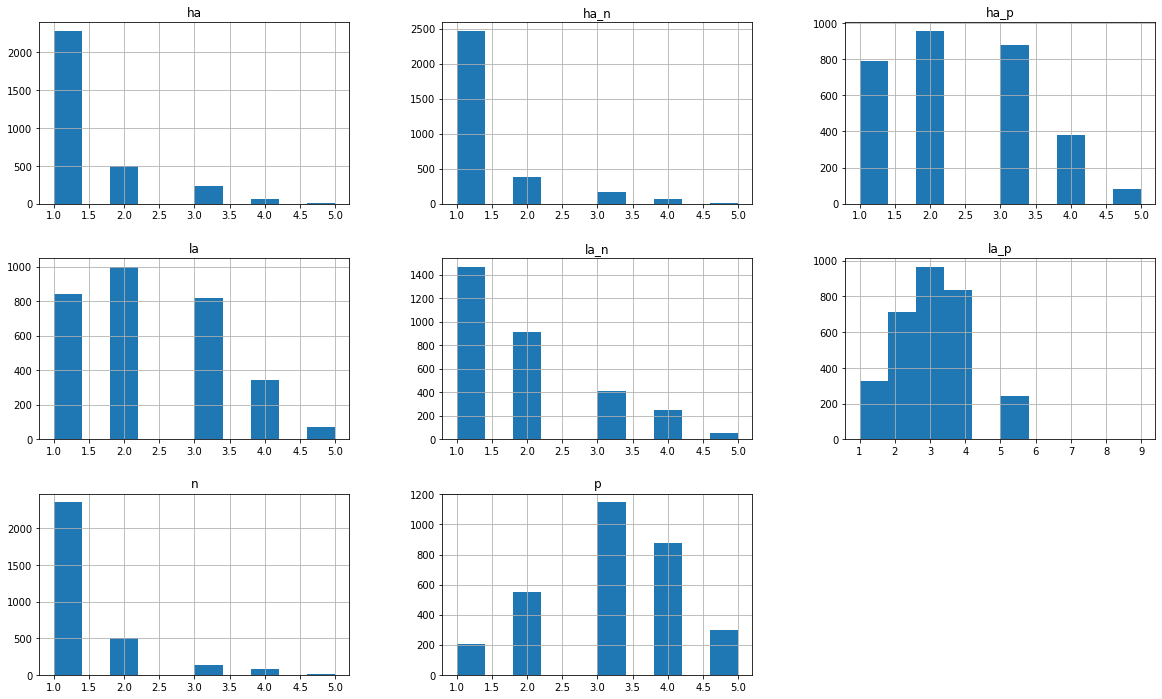

In [0]:
exp[['la_p', 'ha_p', 'ha_n', 'la_n','la', 'p', 'n', 'ha']].hist(figsize=(20,12))

In [0]:
exp[['la_p', 'ha_p', 'ha_n', 'la_n','la', 'p', 'n', 'ha']].describe()

la_p         ha_p  ...            n           ha
count  3082.000000  3083.000000  ...  3083.000000  3083.000000
mean      2.985075     2.356471  ...     1.343172     1.390204
std       1.118914     1.071917  ...     0.719372     0.751720
min       1.000000     1.000000  ...     1.000000     1.000000
25%       2.000000     1.000000  ...     1.000000     1.000000
50%       3.000000     2.000000  ...     1.000000     1.000000
75%       4.000000     3.000000  ...     1.000000     2.000000
max       9.000000     5.000000  ...     5.000000     5.000000

[8 rows x 8 columns]

### (3) Observe Positive / Negative Emotion

In [0]:
# 'pn_raw' represent how happy / unhappy the subjects are
exp['pn_raw'] = (exp['la_p'] + exp['p'] + exp['ha_p'])/3 - (exp['la_n'] + exp['n'] + exp['ha_n'])/3

In [0]:
# Ratio of 'pn_raw' < 0
print('pn_raw < 0: ',str(sum(exp['pn_raw'] < 0)/exp.shape[0]))
print('pn_raw = 0: ',str(sum(exp['pn_raw'] == 0)/exp.shape[0]))
print('pn_raw > 0: ',str(sum(exp['pn_raw'] > 0)/exp.shape[0]))

pn_raw < 0:  0.10866039571845605
pn_raw = 0:  0.04573467401881284
pn_raw > 0:  0.8452805708725267


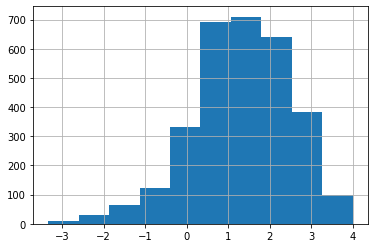

In [0]:
# Histogram of 'pn_raw'
exp['pn_raw'].hist()

## 3.Pre-processing

### (1) Grouping columns for different model
Let's only use predictors with less than 50% missing.

In [0]:
# Update Feature Cols

features_common = ['step_max', 'step_min', 'step_median', 
       
       'steps_max_3h', 'steps_min_3h', 'steps_mean_3h', 'steps_var_3h', 'steps_median_3h', 
       'move_rate_3h', 'active_rate_3h', 'very_active_rate_3h', 'running_rate_3h',
       
       'steps_max_1h', 'steps_min_1h', 'steps_mean_1h', 'steps_var_1h', 'steps_median_1h', 
       'move_rate_1h', 'active_rate_1h', 'very_active_rate_1h', 'running_rate_1h', 
       
       'steps_max_30m', 'steps_min_30m', 'steps_mean_30m', 'steps_var_30m', 'steps_median_30m', 
       'move_rate_30m', 'active_rate_30m', 'very_active_rate_30m', 'running_rate_30m', 
       
       'steps_max_10m', 'steps_min_10m', 'steps_mean_10m', 'steps_var_10m', 'steps_median_10m', 
       'move_rate_10m', 'active_rate_10m', 'very_active_rate_10m', 'running_rate_10m', 
       
       'steps_max_5m', 'steps_min_5m', 'steps_mean_5m', 'steps_var_5m', 'steps_median_5m',
       'move_rate_5m', 'active_rate_5m', 'very_active_rate_5m', 'running_rate_5m', 
       
       'hr_max', 'hr_min', 'hr_med',
       
       'SDNN_3h', 'pHR2_3h', 'rMSSD_3h', 'low_hr_3h', 'high_hr_3h', 'l_h_3h', 'CR_3h', 'hr_mean_3h', 
       'hr_var_3h', 'hr_std_3h', 'hr_median_3h', 'hr_rest_rate_3h', 'hr_moderate_rate_3h',
       'hr_very_active_rate_3h', 
       
       'SDNN_1h', 'pHR2_1h', 'rMSSD_1h', 'low_hr_1h', 'high_hr_1h', 'l_h_1h', 'CR_1h', 'hr_mean_1h',
       'hr_var_1h', 'hr_std_1h', 'hr_median_1h', 'hr_rest_rate_1h',
       'hr_moderate_rate_1h', 'hr_very_active_rate_1h', 
       
       'SDNN_30m', 'pHR2_30m', 'rMSSD_30m', 'low_hr_30m', 'high_hr_30m', 'l_h_30m', 'CR_30m', 'hr_mean_30m', 
       'hr_var_30m', 'hr_std_30m', 'hr_median_30m', 'hr_rest_rate_30m', 
       'hr_moderate_rate_30m', 'hr_very_active_rate_30m', 
       
       'SDNN_10m', 'pHR2_10m', 'rMSSD_10m', 'low_hr_10m', 'high_hr_10m', 'l_h_10m', 'CR_10m', 'hr_mean_10m',
       'hr_var_10m', 'hr_std_10m', 'hr_median_10m', 'hr_rest_rate_10m',
       'hr_moderate_rate_10m', 'hr_very_active_rate_10m', 
       
       'SDNN_5m', 'pHR2_5m', 'rMSSD_5m', 'low_hr_5m', 'high_hr_5m', 'l_h_5m',
       'CR_5m', 'hr_mean_5m', 'hr_var_5m', 'hr_std_5m', 'hr_median_5m',
       'hr_rest_rate_5m', 'hr_moderate_rate_5m', 'hr_very_active_rate_5m',
       
       'hr_0', 'hr_0.3', 'hr_0.5', 'hr_0.8', 'hr_1', 
       
       'SBQ', 'FTP', 'SWLS', 'Neuroticism', 'Extraversion', 'Conscientiousness',
       'NS_total', 'BIS_total', 'BIS.5', 'BAS_D', 'BAS_FS', 'BAS_RR',
       'HAP_actual', 'P_actual', 'LAP_actual', 'LA_actual', 'LAN_actual',
       'N_actual', 'HAN_actual', 'HA_actual', 'HAP_ideal', 'P_ideal',
       'LAP_ideal', 'LA_ideal', 'LAN_ideal', 'N_ideal', 'HAN_ideal',
       'HA_ideal', 'survey_hour'
       
       ]

features_lite = ['step_max', 'step_min', 'step_median', 
       
      #  'steps_max_3h', 'steps_min_3h', 'steps_mean_3h', 'steps_var_3h', 'steps_median_3h', 
      #  'move_rate_3h', 'active_rate_3h', 'very_active_rate_3h', 'running_rate_3h',
       
       'steps_max_1h', 'steps_min_1h', 
       'steps_var_1h', 'steps_median_1h', 
       'active_rate_1h', 
       #'move_rate_1h', 'very_active_rate_1h', 'steps_mean_1h', 'running_rate_1h',  
       
      #  'steps_max_30m', 'steps_min_30m', 'steps_mean_30m', 'steps_var_30m', 'steps_median_30m', 
      #  'move_rate_30m', 'active_rate_30m', 'very_active_rate_30m', 'running_rate_30m', 
       
       'steps_max_10m', 'steps_min_10m', 
       'steps_var_10m', 'steps_median_10m', 
       'move_rate_10m', 
       # 'very_active_rate_10m', 'active_rate_10m', 'steps_mean_10m',
       'running_rate_10m', 
       
      #  'steps_max_5m', 'steps_min_5m', 'steps_mean_5m', 'steps_var_5m', 'steps_median_5m',
      #  'move_rate_5m', 'active_rate_5m', 'very_active_rate_5m', 'running_rate_5m', 
       
       'hr_max', 'hr_min', 'hr_med',
       
       'SDNN_3h', 'pHR2_3h', 'rMSSD_3h', 'low_hr_3h', 'high_hr_3h', 'l_h_3h', 'CR_3h', 
      #  'hr_mean_3h', 
      #  'hr_var_3h', 'hr_std_3h', 'hr_median_3h', 'hr_rest_rate_3h', 'hr_moderate_rate_3h',
      #  'hr_very_active_rate_3h', 
       
       'SDNN_1h', 'pHR2_1h', 'high_hr_1h', 'l_h_1h', 'hr_mean_1h',
       #'rMSSD_1h', 'low_hr_1h', 'CR_1h', 'hr_median_1h', 'hr_var_1h', 
       'hr_std_1h', 'hr_rest_rate_1h',
       'hr_moderate_rate_1h', 'hr_very_active_rate_1h', 
       
       'SDNN_30m', 'pHR2_30m', 'rMSSD_30m', 'low_hr_30m', 'high_hr_30m', 'l_h_30m', 'CR_30m', 
      #  'hr_mean_30m', 
      #  'hr_var_30m', 'hr_std_30m', 'hr_median_30m', 'hr_rest_rate_30m', 
      #  'hr_moderate_rate_30m', 'hr_very_active_rate_30m', 
       
       'SDNN_10m', 'pHR2_10m', 'rMSSD_10m', 'l_h_10m', 
       # 'hr_mean_10m', 'hr_var_10m', 'hr_median_10m', 'low_hr_10m', 'high_hr_10m', 'CR_10m', 
       'hr_std_10m',  'hr_rest_rate_10m',
       'hr_moderate_rate_10m', 'hr_very_active_rate_10m', 
       
       'SDNN_5m', 'pHR2_5m', 'rMSSD_5m', 'low_hr_5m', 'high_hr_5m', 'l_h_5m',
       'CR_5m', 
      #  'hr_mean_5m', 'hr_var_5m', 'hr_std_5m', 'hr_median_5m',
      #  'hr_rest_rate_5m', 'hr_moderate_rate_5m', 'hr_very_active_rate_5m',
       
       'hr_0', 'hr_0.3', 'hr_0.8', 'hr_1', # 'hr_0.5',
       
       'SBQ', 'SWLS', 'Neuroticism', 'Extraversion', 
       'NS_total', 'BIS_total', 'BIS.5', 'BAS_D', 'BAS_FS', 'BAS_RR',
       'Age', 'BMI', 'Children',
      # 'FTP', 'Conscientiousness',
      #  'HAP_actual', 'P_actual', 'LAP_actual', 'LA_actual', 'LAN_actual',
      #  'N_actual', 'HAN_actual', 'HA_actual', 'HAP_ideal', 'P_ideal',
      #  'LAP_ideal', 'LA_ideal', 'LAN_ideal', 'N_ideal', 'HAN_ideal',
      #  'HA_ideal', 
      'survey_hour'
       
       ]


feature_encode = ['exp', 'income', 'have_med', 'is_female',
                'is_married', 'is_divorced', 'is_single', 'is_widowed', 
                'is_with_partner', 'is_wht', 'is_hsp_other', 'is_blk', 
                'is_hsp_caucasian', 'is_birace', 'is_hsp', 'is_asn', 
                'is_white_pacific', 'is_hwi', 'edu_hs', 'edu_ba', 'edu_ma', 
                'edu_phd']
feature_ca = ['edu', 'Ethnicity', 'Sex', 'Marital_Status',
              'have_med', 'experiment']
subject = ['subject']
feature_num = features_common + feature_encode + subject
feature_num_lite = features_lite + feature_encode
feature_cols_ca = features_common + feature_ca
label_cols = ['la_p', 'ha_p', 'ha_n', 'la_n', 'la', 'p', 'n', 'ha']

In [0]:
# Generate design matrix
exp.loc[:,'edu'] = 0
exp.loc[:,'have_med'] = 0

design_matrix = exp[features_common + feature_ca + label_cols + subject]

In [0]:
# Drop NA
# design_matrix = design_matrix.dropna()

In [0]:
design_matrix.shape

(3083, 170)

### (2) Generate Labels

In [0]:
exp['pn_raw'] = (exp['la_p'] + exp['p'] + exp['ha_p'])/3 \
        - (exp['la_n'] + exp['n'] + exp['ha_n'])/3

In [0]:
# Create dummy variable for valence, with 1 to be unhappy, and 0 to be happy.
exp.loc[:,'valence'] = 0
exp.loc[exp['pn_raw'] <= 0, 'valence'] = 1

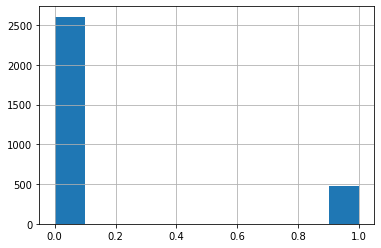

In [0]:
exp['valence'].hist()

As you can see, this is very imbalanced data. Let's use a logistic regression to start.

### (3) Encode Categorical Data

i. List All Categorical Data

In [0]:
# Categorical Features
exp.columns[exp.dtypes == 'object']

Index(['subject', 'start_survey', 'experiment', 'DATE_x', 'Period_of_day',
       'start_survey_5m_ahead', 'start_survey_10m_ahead',
       'start_survey_30m_ahead', 'start_survey_1h_ahead',
       'start_survey_3h_ahead', 'survey_date', 'subject_id_x', 'subject_id_y',
       'Date', 'Experiment', 'Subject', 'Education', 'Ethnicity', 'Sex',
       'Marital_Status', 'Household_income', 'Religion', 'Medications'],
      dtype='object')

ii. Convert Education

In [0]:
exp['Education'].unique()

MBA = ['MBA', 'High School Diploma, BA, MBA', 'B.S. Business Management', 'BS Business','College grad']
Art = ['Bachelor of Arts', 'Bachelor of Arts + Equivalency Degree', 'Bachelor Degree Music Ed']
Med = ['Medical Degree', 'B.A. English/Spanish B.S. Nursing', 'BSN- bachelors of science in nursing']
Psy = ['Education specialist in School Psy, M.A. in Educational Psy', 'M.S. Psychology/ B.A. Sociology', 'B.S. Psychology Texas A&M']


HighSchool = ['12.0','high school', 'High School', 'high school + cosmetology school', 'High School Graduate']
BA = ['Some college', 'B.A. English/Spanish B.S. Nursing', 'B.S. working on MD and MTS', 'B.S.  Mechanical Engineering', 
      "Bachelor's Degree", 'B.A.', 'College student 3 years', 'B.A. from Cornell Univ.', 'Bachelors degree in Social Work', 
      'BS', 'BA Vanderbilt', 'BS Communications', "college graduate (bachelor's degree in Music from Belmont University)",
      'Bachelor of Arts', 'BSN- bachelors of science in nursing', 'BSE Princeton',
      'Obtained B.S., 2011', 'bachelor of science', 'Bachelor of Social Work', 'B.S.', 'BBA - Bachelors', 'BSC Communications',
      'B.A. 1988', 'B.S. degree dietetics, internship', 'Bachelor of Arts + Equivalency Degree', 'Bachelors', 'B.S. Business Management',
      'B.S. Psychology Texas A&M', 'BS Journalism; BS Nutrition', 'B.E.Sc.', 'Bachelor Degree Music Ed', 'NDCDP',
      'BS Math/Computer Science', 'BS Business', 'college graduate','14.0','16.0']
Master = MBA + ['College, Masters',"Bachelor of science, 1 year of Master's",'Masters; PhD ongoing', 'M.S. Psychology/ B.A. Sociology',
                'B.S., MPH','18.0', '19.0']
PhD = ['Ph.D.', 'PhD Candidate', 'PhD', 'BS. (PhD Student currently)', 'Masters; PhD ongoing', 
       'Pursuing PhD at Vanderbilt. Have B.S. from UTK', 'BA from Stanford, JD from Univ of Michigan','21.0', '22.0', '20.0']

In [0]:
# design_matrix['is_MBA'] = 0
# design_matrix.loc[design_matrix['Education'].isin(MBA), 'is_MBA'] = 1
# design_matrix['is_Art'] = 0
# design_matrix.loc[design_matrix['Education'].isin(Art), 'is_Art'] = 1
# design_matrix['is_Med'] = 0
# design_matrix.loc[design_matrix['Education'].isin(Med), 'is_Med'] = 1
# design_matrix['is_Psy'] = 0
# design_matrix.loc[design_matrix['Education'].isin(Psy), 'is_Psy'] = 1

exp.loc[:,'edu'] = 0
exp.loc[:,'edu_hs'] = 0
exp.loc[exp['Education'].isin(HighSchool), 'edu_hs'] = 1
exp.loc[exp['Education'].isin(HighSchool), 'edu'] = 'high school'
exp.loc[:,'edu_ba'] = 0
exp.loc[exp['Education'].isin(BA), 'edu_ba'] = 1
exp.loc[exp['Education'].isin(BA), 'edu'] = 'undergrad'
exp.loc[:,'edu_ma'] = 0
exp.loc[exp['Education'].isin(Master), 'edu_ma'] = 1
exp.loc[exp['Education'].isin(Master), 'edu'] = 'master'
exp.loc[:,'edu_phd'] = 0
exp.loc[exp['Education'].isin(PhD), 'edu_phd'] = 1
exp.loc[exp['Education'].isin(PhD), 'edu'] = 'phd'

iii. Convert Ethnicity

In [0]:
design_matrix['Ethnicity'].unique()

array(['White', 'Hispanic/Other', 'Black', 'Hispanic/Caucasian',
       'Biracial', 'Hispanic', 'Asian', 'White/Pacific Islander', nan,
       'Native Hawaiian/Pacific Islander', 'More than 1 race'],
      dtype=object)

In [0]:
exp.loc[:,'is_wht'] = 0
exp.loc[exp['Ethnicity'] == 'White', 'is_wht'] = 1
exp.loc[:,'is_hsp_other'] = 0
exp.loc[exp['Ethnicity'] == 'Hispanic/Other', 'is_hsp_other'] = 1
exp.loc[:,'is_blk'] = 0
exp.loc[exp['Ethnicity'] == 'Black', 'is_blk'] = 1
exp.loc[:,'is_hsp_caucasian'] = 0
exp.loc[exp['Ethnicity'] == 'Hispanic/Caucasian', 'is_hsp_caucasian'] = 1
exp.loc[:,'is_birace'] = 0
exp.loc[exp['Ethnicity'].isin(['Biracial', 'More than 1 race']), 'is_birace'] = 1
exp.loc[:,'is_hsp'] = 0
exp.loc[exp['Ethnicity'] == 'Hispanic', 'is_hsp'] = 1
exp.loc[:,'is_asn'] = 0
exp.loc[exp['Ethnicity'] == 'Asian', 'is_asn'] = 1
exp.loc[:,'is_white_pacific'] = 0
exp.loc[exp['Ethnicity'] == 'White/Pacific Islander', 'is_white_pacific'] = 1
exp.loc[:,'is_hwi'] = 0
exp.loc[exp['Ethnicity'] == 'Native Hawaiian/Pacific Islander', 'is_hwi'] = 1

iv. Sex

In [0]:
exp['Sex'].unique()
# Drop NA in Sex column
exp = exp[~exp['Sex'].isna()]
exp.shape

(3058, 223)

In [0]:
exp['is_female'] = 0
exp.loc[exp['Sex'] == 'Female', 'is_female'] = 1

v. Marital_Status

In [0]:
exp['Marital_Status'].unique()

array(['Married', 'Divorced', 'Single', 'Engaged', 'Widowed',
       'Living with partner'], dtype=object)

In [0]:
exp.loc[:,'is_married'] = 0
exp.loc[design_matrix['Marital_Status'] == 'Married', 'is_married'] = 1
exp.loc[:,'is_divorced'] = 0
exp.loc[design_matrix['Marital_Status'] == 'Divorced', 'is_divorced'] = 1
exp.loc[:,'is_single'] = 0
exp.loc[design_matrix['Marital_Status'] == 'Single', 'is_single'] = 1
exp.loc[:,'is_widowed'] = 0
exp.loc[design_matrix['Marital_Status'] == 'Widowed', 'is_widowed'] = 1
exp.loc[:,'is_with_partner'] = 0
exp.loc[design_matrix['Marital_Status'] == 'Living with partner', 'is_with_partner'] = 1

vi. Household_income

In [0]:
exp['Household_income'].unique()
# Drop NA in Household_income column
exp = exp[~exp['Household_income'].isna()]
exp.shape

(3029, 229)

In [0]:
exp.loc[:,'income'] = 0
exp.loc[exp['Household_income'] == '$10,000-$19,999', 'income'] = 1
exp.loc[exp['Household_income'] == '$20,000-$29,999', 'income'] = 2
exp.loc[exp['Household_income'] == '$30,000-$39,999', 'income'] = 3
exp.loc[exp['Household_income'] == '$40,000-$49,999', 'income'] = 4
exp.loc[exp['Household_income'] == '$50,000-$59,999', 'income'] = 5
exp.loc[exp['Household_income'] == '$60,000-$69,999', 'income'] = 6
exp.loc[exp['Household_income'] == '$70,000-$79,999', 'income'] = 7
exp.loc[exp['Household_income'] == '$80,000-$89,999', 'income'] = 8
exp.loc[exp['Household_income'] == '$90,000-$99,999', 'income'] = 9
exp.loc[exp['Household_income'] == '$100,000-$109,999', 'income'] = 10
exp.loc[exp['Household_income'] == '$110,000-$119,999', 'income'] = 11
exp.loc[exp['Household_income'] == '$120,000-$129,999', 'income'] = 12
exp.loc[exp['Household_income'] == '$130,000-$139,000', 'income'] = 13
exp.loc[exp['Household_income'] == '$140,000-$149,999', 'income'] = 14
exp.loc[exp['Household_income'].isin(['$150,000 or more ','$150,000 or more']), 'income'] = 15

vii. Medications

In [0]:
exp['Medications'].unique()

array(['None', 'None listed', 'BP med, cholesterol med', 'Camrese',
       'Ortho-tri-sprintic (oral contraceptive)', 'Birth control (oral)',
       'Occaisonal OTC allergy and/or cold medicine',
       'Pravachol, Claritin', 'Naproxen, omeprazole',
       'Adult multivitamin, fish oil supplement, Vitamin E, Calcium+ Vitamin D supplement, Magnesium Oxide Supplement, D3 supplement, Biotin',
       'Aciphex', 'Levothyroxin, provastatin',
       'Lipitor, Diovan, 81mg Aspirin', 'Curbimide, Thyroid Med, Aspirin',
       'Vit D3, Levonogestrel/ethinyl, estradiol',
       'Lisinopril, water pill', 'Atorvastatin', 'IUD birth control',
       'Aspirin as needed', nan, 'Loloestrin', 'Mossa', 'birth control',
       'finasteride', 'Lutera (birth control)', 'lo-ogestrel (cryselle)',
       'Vitamin D supplements', 'albuterol was needed for asthma',
       'Reclipsen (Birth Control Pill)', 'Portia',
       'Mobic - antiinflammatory', 'clobetasol',
       'Spironolactone 100 mg PO Q Day',
       't

In [0]:
exp.loc[:,'have_med'] = 1
exp.loc[exp['Medications'] == 'None', 'have_med'] = 0

viii. Exp

In [0]:
# 'DND' = 0, 'ROO' = 1
exp['exp'] = 1
exp.loc[exp['experiment'] == 'DND', 'exp'] = 0

### (4) Detect Correlation

In [0]:
corr_matrix = exp[feature_num].corr()

In [0]:
corr_matrix_df = pd.DataFrame(corr_matrix.unstack())
corr_matrix_df.columns = ['corr']

In [0]:
# Filter pairs which are highly correlated
corr_matrix_df[(corr_matrix_df['corr'] > 0.9) & (corr_matrix_df['corr'] < 1)]

corr
steps_mean_3h           very_active_rate_3h      0.944557
                        running_rate_3h          0.970005
move_rate_3h            active_rate_3h           0.982064
                        very_active_rate_3h      0.928990
active_rate_3h          move_rate_3h             0.982064
                        very_active_rate_3h      0.973290
                        running_rate_3h          0.917322
very_active_rate_3h     steps_mean_3h            0.944557
                        move_rate_3h             0.928990
                        active_rate_3h           0.973290
                        running_rate_3h          0.977516
running_rate_3h         steps_mean_3h            0.970005
                        active_rate_3h           0.917322
                        very_active_rate_3h      0.977516
steps_mean_1h           very_active_rate_1h      0.927333
                        running_rate_1h          0.959266
move_rate_1h            active_rate_1h           0.972596
                        very_active_rate_1h      0.909354
active_rate_1h          move_rate_1h             0.972596
                        very_active_rate_1h      0.967026
                        running_rate_1h          0.905872
very_active_rate_1h     steps_mean_1h            0.927333
                        move_rate_1h             0.909354
                        active_rate_1h           0.967026
                        running_rate_1h          0.972520
running_rate_1h         steps_mean_1h            0.959266
                        active_rate_1h           0.905872
                        very_active_rate_1h      0.972520
steps_mean_30m          steps_median_30m         0.920333
                        very_active_rate_30m     0.923085
                        running_rate_30m         0.957074
steps_median_30m        steps_mean_30m           0.920333
move_rate_30m           active_rate_30m          0.969008
                        very_active_rate_30m     0.901710
active_rate_30m         move_rate_30m            0.969008
                        very_active_rate_30m     0.961484
very_active_rate_30m    steps_mean_30m           0.923085
                        move_rate_30m            0.901710
                        active_rate_30m          0.961484
                        running_rate_30m         0.966914
running_rate_30m        steps_mean_30m           0.957074
                        very_active_rate_30m     0.966914
steps_mean_10m          steps_median_10m         0.951602
                        very_active_rate_10m     0.909685
                        running_rate_10m         0.942009
                        steps_mean_5m            0.902805
steps_median_10m        steps_mean_10m           0.951602
move_rate_10m           active_rate_10m          0.953320
                        move_rate_5m             0.904177
active_rate_10m         move_rate_10m            0.953320
                        very_active_rate_10m     0.941897
very_active_rate_10m    steps_mean_10m           0.909685
                        active_rate_10m          0.941897
                        running_rate_10m         0.940211
running_rate_10m        steps_mean_10m           0.942009
                        very_active_rate_10m     0.940211
steps_max_5m            steps_mean_5m            0.906970
steps_mean_5m           steps_mean_10m           0.902805
                        steps_max_5m             0.906970
                        steps_median_5m          0.966001
                        running_rate_5m          0.923614
steps_median_5m         steps_mean_5m            0.966001
move_rate_5m            move_rate_10m            0.904177
                        active_rate_5m           0.939527
active_rate_5m          move_rate_5m             0.939527
                        very_active_rate_5m      0.921852
very_active_rate_5m     active_rate_5m           0.921852
                        running_rate_5m          0.916397
running_rate_5m         steps_mean_5m            0.

As we can see, the correlation exist in 'mean' and 'median' fetaures, 'var' and 'std' features. Let's get rid of them by changing feature columns.

In [0]:
# Check correlation again
corr_matrix = exp[feature_num_lite].corr()
corr_matrix_df = pd.DataFrame(corr_matrix.unstack())
corr_matrix_df.columns = ['corr']
# Filter pairs which are highly correlated
corr_matrix_df[(corr_matrix_df['corr'] > 0.9) & (corr_matrix_df['corr'] < 1)]

Empty DataFrame
Columns: [corr]
Index: []

### (5) Split the Data with one-hot encoding by Subject

In [0]:
# Construct design matrix for logistic regression. Categorical features are one-hot encoded
design_matrix_onehot = exp[feature_num_lite + subject + ['valence']].dropna()
design_matrix_onehot.shape

(2133, 97)

In [0]:
# Grouped Data-Split, by subject, prevent information leakage
X_oh = design_matrix_onehot[feature_num_lite]
y_oh = design_matrix_onehot['valence']
group = design_matrix_onehot['subject'].values
gkf_modeling = list(GroupKFold(n_splits=4).split(X_oh,y_oh,group))

X_oh_train = X_oh.iloc[gkf_modeling[1][0],]
X_oh_test = X_oh.iloc[gkf_modeling[1][1],]
y_oh_train = y_oh.iloc[gkf_modeling[1][0],]
y_oh_test = y_oh.iloc[gkf_modeling[1][1],]

# Normalization
scaler = preprocessing.StandardScaler().fit(X_oh_train)
X_oh_train_scaled = scaler.transform(X_oh_train)
X_oh_test_scaled = scaler.transform(X_oh_test)

### (6) Split the Data with categorical feature by Subject

In [0]:
# Construct design matrix for lther regression. Categorical features are not one-hot encoded
design_matrix_for_cat = exp[feature_cols_ca + subject + ['valence']].dropna()
design_matrix_for_cat.shape

(2133, 163)

In [0]:
# Grouped Data-Split, by subject, prevent information leakage
X_cat = design_matrix_for_cat[feature_cols_ca]
y_cat = design_matrix_for_cat['valence']
group = design_matrix_for_cat['subject'].values
gkf_modeling = list(GroupKFold(n_splits=4).split(X_cat,y_cat,group))

X_cat_train = X_cat.iloc[gkf_modeling[1][0],]
X_cat_test = X_cat.iloc[gkf_modeling[1][1],]
y_cat_train = y_cat.iloc[gkf_modeling[1][0],]
y_cat_test = y_cat.iloc[gkf_modeling[1][1],]

## 4.Baseline Model - Logistic Regression

### (1) Modeling

In [0]:
lg1 = LogisticRegression(max_iter=20000)

In [0]:
lg1.fit(X_oh_train_scaled, y_oh_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=20000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### (2) Prediction

In [0]:
lg1_pred = lg1.predict(X_oh_test_scaled)
lg1_prob = lg1.predict_proba(X_oh_test_scaled)

### (3) Evaluation

In [0]:
def eval_class(y_test, y_pred):
  '''
  This function evaluates the model performance
  in terms of Accuracy, Recall, Precision, Specificity and F1
  
  Parameters:
  y_test (array):     Test label
  y_pred (array):     Model prediction

  Returns:
  Evaluation information printed
  array contains [accuracy, recall, precision, specificity, npv, f1]
  '''
  # Accuracy
  accuracy = accuracy_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
  specificity = tn / (tn+fp)
  npv = tn / (tn+fn)
  f1 = f1_score(y_test, y_pred)

  print('Accuracy: \t', str(accuracy))
  print('Recall: \t', str(recall))
  print('Precision: \t', str(precision))
  print('Specificity: \t', str(specificity))
  print('NPV: \t', str(npv))
  print('F1: \t\t', str(f1))
  return [accuracy, recall, precision, specificity, npv, f1]

In [0]:
def plot_roc(y_test,  prob, model_type):
  '''
  This function plots RoC curve for classfication algotrithms.
  
  Parameters:
  y_test (array):       Test label
  prob (array):         Model prediction of probability for binary class
  model_type (string):  Model names

  Returns: 
  RoC plot
  '''
  preds = prob[:,1]
  fpr, tpr, threshold = roc_curve(y_test, preds)
  roc_auc = auc(fpr, tpr)
  if roc_auc < 0.5:
    preds = prob[:,0]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
  # Plot
  plt.title(model_type+ ' RoC')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

In [0]:
def confision_matrix(y_test, y_pred, model_type):
  '''
  This function plots confision matrix for classfication algotrithms.
  
  Parameters:
  y_test (array):     Test label
  y_pred (array):     Model prediction
  model_type (string):  Model names

  Returns: 
  Confusion Matrix plot
  '''
  cm_2 = confusion_matrix(y_test, y_pred) 
  cm_2_df = pd.DataFrame(cm_2)

  plt.figure(figsize=(5.5,4))
  sns.heatmap(cm_2_df, annot=True)
  accuracy = accuracy_score(y_test, y_pred)
  plt.title(model_type + ' Confusion Matrix \nAccuracy:{0:.3f}'.format(accuracy))
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

In [0]:
def plot_pr_curve(y_test, prob, y_pred, model_type):
  '''
  This function plots PR curve for classfication algotrithms.
  
  Parameters:
  y_test (array):       Test label
  prob (array):         Model prediction of probability for binary class
  y_pred (array):     Model prediction
  model_type (string):  Model names

  Returns: 
  PR plot
  '''
  lr_precision, lr_recall, _ = precision_recall_curve(y_test, prob[:,1])
  lr_f1, lr_auc = f1_score(y_test, y_pred), auc(lr_recall, lr_precision)
  # summarize scores
  print(model_type, ' PR Curve: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
  # plot the precision-recall curves
  unhappy = len(y_test[y_test==1]) / len(y_test)
  plt.plot([0, 1], [unhappy, unhappy], linestyle='--', label='Unhappy')
  plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
  # axis labels
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  # show the legend
  plt.legend()
  # show the plot
  plt.show()

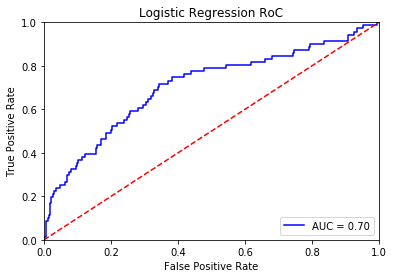

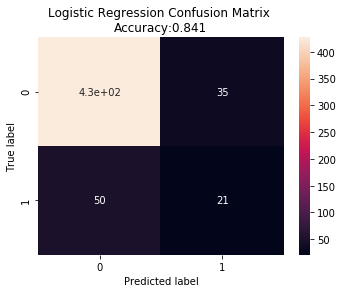

Logistic Regression  PR Curve: f1=0.331 auc=0.324


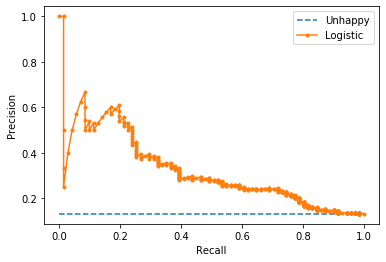

Accuracy: 	 0.8405253283302064
Recall: 	 0.29577464788732394
Precision: 	 0.375
Specificity: 	 0.9242424242424242
NPV: 	 0.8951781970649895
F1: 		 0.3307086614173228


In [0]:
def eval(y_test, prob, y_pred, model_type):
  plot_roc(y_test, prob, model_type)
  confision_matrix(y_test, y_pred, model_type)
  plot_pr_curve(y_test, prob, y_pred, model_type)
  eval_class(y_test, y_pred)

eval(y_oh_test, lg1_prob, lg1_pred, 'Logistic Regression')

All results are 1, we are suffering from imbalanced data. Let's try Random Forest.

## 5.Random Forest - Less vunerable to imbalanced data

### (1) Modeling

In [0]:
rf1 = RandomForestClassifier(n_estimators=100).fit(X_oh_train, y_oh_train)

###(2) Prediction

In [0]:
rf1_pred = rf1.predict(X_oh_test)
rf1_prob = rf1.predict_proba(X_oh_test)

### (3) Evaluation

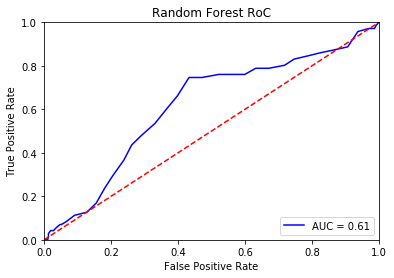

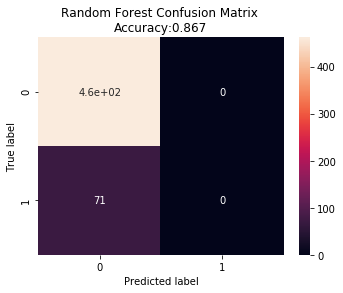

Random Forest  PR Curve: f1=0.000 auc=0.174


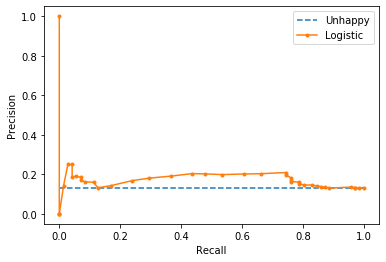

Accuracy: 	 0.8667917448405253
Recall: 	 0.0
Precision: 	 0.0
Specificity: 	 1.0
NPV: 	 0.8667917448405253
F1: 		 0.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
eval(y_oh_test, rf1_prob, rf1_pred, 'Random Forest')

Still not perform well. Let's try to model using random split data.

## 6.CatBoost

Let me just try it.

### (1) Modeling

In [0]:
categorical_features_indices = np.where(X_cat_train.dtypes != np.float)[0]

In [0]:
# Model params
params_1 = {
    'loss_function': 'MultiClass',
    'eval_metric': 'Accuracy',
    'verbose': 10,
    'random_seed': 24,
    # 'depth':6, 
    'learning_rate':0.0001,
    'use_best_model': True,
    'l2_leaf_reg': 10,
    'bagging_temperature': 3,
    'od_type': "Iter",
    'od_wait': 100
}

cat1 = catboost.CatBoostClassifier(**params_1)
cat1.fit(X_cat_train, y_cat_train,
             eval_set = (X_cat_test, y_cat_test),
             use_best_model = True,
             cat_features = categorical_features_indices,
             plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8493750	test: 0.8686679	best: 0.8686679 (0)	total: 242ms	remaining: 4m 2s
10:	learn: 0.8406250	test: 0.8667917	best: 0.8686679 (0)	total: 791ms	remaining: 1m 11s
20:	learn: 0.8406250	test: 0.8667917	best: 0.8686679 (0)	total: 1.3s	remaining: 1m
30:	learn: 0.8406250	test: 0.8667917	best: 0.8686679 (0)	total: 1.81s	remaining: 56.7s
40:	learn: 0.8406250	test: 0.8667917	best: 0.8686679 (0)	total: 2.33s	remaining: 54.4s
50:	learn: 0.8406250	test: 0.8667917	best: 0.8686679 (0)	total: 2.87s	remaining: 53.3s
60:	learn: 0.8406250	test: 0.8667917	best: 0.8686679 (0)	total: 3.38s	remaining: 52.1s
70:	learn: 0.8406250	test: 0.8667917	best: 0.8686679 (0)	total: 3.89s	remaining: 51s
80:	learn: 0.8406250	test: 0.8667917	best: 0.8686679 (0)	total: 4.42s	remaining: 50.1s
90:	learn: 0.8406250	test: 0.8667917	best: 0.8686679 (0)	total: 4.92s	remaining: 49.2s
100:	learn: 0.8406250	test: 0.8667917	best: 0.8686679 (0)	total: 5.45s	remaining: 48.5s
Stopped by overfitting detector  (100 iterations

### (2) Prediction

In [0]:
cat1_pred = cat1.predict(X_cat_test)
cat1_prob = cat1.predict_proba(X_cat_test)

### (3) Evaluation

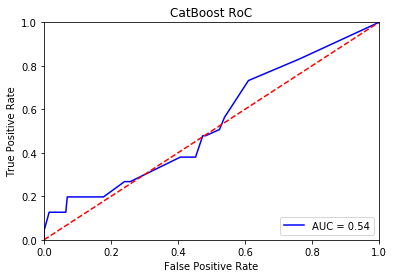

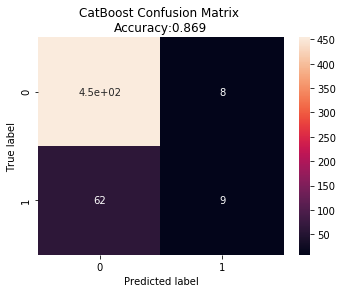

CatBoost  PR Curve: f1=0.205 auc=0.239


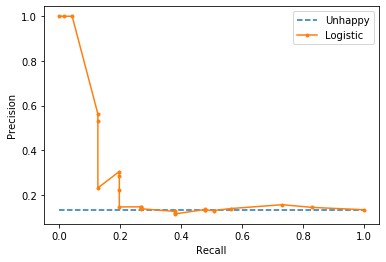

Accuracy: 	 0.8686679174484052
Recall: 	 0.1267605633802817
Precision: 	 0.5294117647058824
Specificity: 	 0.9826839826839827
NPV: 	 0.8798449612403101
F1: 		 0.20454545454545459


In [0]:
eval(y_cat_test, cat1_prob, cat1_pred, 'CatBoost')

In [0]:
def catboost_feature_importance(model, feature_col):
  # Extract feature importance
  feature_importance = pd.Series(model.feature_importances_)
  feature_name = pd.Series(feature_col)
  feature_importance_score = pd.DataFrame(dict(feature_name = feature_name, score = feature_importance))
  # Sort by score
  return feature_importance_score.sort_values(by='score', ascending=False)
  # print(feature_importance_score.head(20))

In [0]:
cat1_feature_score = catboost_feature_importance(cat1, X_cat_test.columns.values)
cat1_feature_score.head(20)

feature_name      score
129              Neuroticism  37.953695
131        Conscientiousness  33.109563
151                  N_ideal  10.285097
110                low_hr_5m   8.269714
52                   pHR2_3h   5.353117
72                hr_mean_1h   5.028815
104         hr_rest_rate_10m   0.000000
105     hr_moderate_rate_10m   0.000000
106  hr_very_active_rate_10m   0.000000
107                  SDNN_5m   0.000000
108                  pHR2_5m   0.000000
109                 rMSSD_5m   0.000000
0                   step_max   0.000000
102               hr_std_10m   0.000000
111               high_hr_5m   0.000000
112                   l_h_5m   0.000000
113                    CR_5m   0.000000
114               hr_mean_5m   0.000000
115                hr_var_5m   0.000000
116                hr_std_5m   0.000000

CatBoost is still suffer from imbalanced data. Let's use sampling technology to remedy imbalanced data.

## 7.Over Sample Minority Class

### (1) Upsample for Data with categorical feature

In [0]:
def upsample_data_with_cat(X_train, y_train):
  # concatenate our training data back together
  data_cat_to_sample = pd.concat([X_train, y_train], axis=1)

  # separate minority and majority classes
  unhappy_cat = data_cat_to_sample[data_cat_to_sample['valence']==1]
  happy_cat = data_cat_to_sample[data_cat_to_sample['valence']==0]


  # upsample minority
  unhappy_cat_upsampled = resample(unhappy_cat,
                            replace=True, # sample with replacement
                            n_samples=len(happy_cat), # match number in majority class
                            random_state=27) # reproducible results

  # combine majority and upsampled minority
  upsampled_cat = pd.concat([happy_cat, unhappy_cat_upsampled])

  # check new class counts
  print(upsampled_cat['valence'].value_counts())

  # Split train and test
  y_upsample_train = upsampled_cat['valence']
  X_upsample_train = upsampled_cat.drop('valence', axis=1)

  return X_upsample_train, y_upsample_train

X_cat_upsample_train, y_cat_upsample_train = upsample_data_with_cat(X_cat_train, y_cat_train)

1    1345
0    1345
Name: valence, dtype: int64


### (2) Upsample Data for design matrix with one-hot encoding

In [0]:
def upsample_data_with_oh(X_train, y_train, X_test):
  # concatenate our training data back together
  data_to_sample = pd.concat([X_train, y_train], axis=1)

  # separate minority and majority classes
  unhappy = data_to_sample[data_to_sample['valence']==1]
  happy = data_to_sample[data_to_sample['valence']==0]

  # upsample minority
  unhappy_upsampled = resample(unhappy,
                            replace=True, # sample with replacement
                            n_samples=len(happy), # match number in majority class
                            random_state=27) # reproducible results

  # combine majority and upsampled minority
  upsampled = pd.concat([happy, unhappy_upsampled])

  # check new class counts
  print(upsampled['valence'].value_counts())

  # Split train and test
  y_upsample_train = upsampled['valence']
  X_upsample_train = upsampled.drop('valence', axis=1)

  # Scale for logistic regression
  scaler = preprocessing.StandardScaler().fit(X_upsample_train)
  X_upsample_train_scaled = scaler.transform(X_upsample_train)
  X_test_scaled = scaler.transform(X_test)

  return X_upsample_train_scaled, y_upsample_train, X_test_scaled

X_oh_upsample_train_scaled, y_oh_upsample_train, X_oh_test_scaled = upsample_data_with_oh(X_oh_train, y_oh_train, X_oh_test)

1    1345
0    1345
Name: valence, dtype: int64


### (3) Logistic Regression

i. Modeling

In [0]:
lg2 = LogisticRegression(max_iter=20000)
lg2.fit(X_oh_upsample_train_scaled, y_oh_upsample_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=20000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

ii. Prediction

In [0]:
lg2_pred = lg2.predict(X_oh_test_scaled)
lg2_prob = lg2.predict_proba(X_oh_test_scaled)

iiii. Evaluation

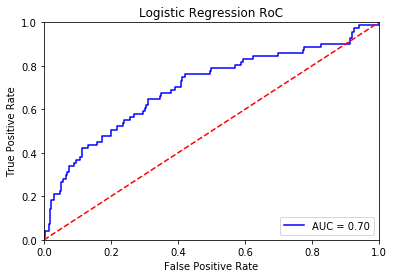

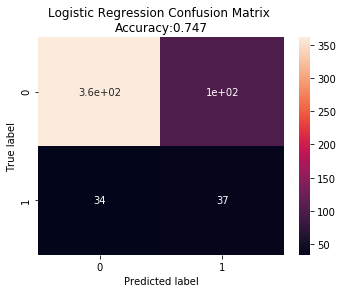

Logistic Regression  PR Curve: f1=0.354 auc=0.318


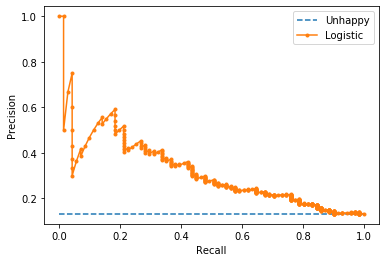

Accuracy: 	 0.7467166979362101
Recall: 	 0.5211267605633803
Precision: 	 0.26811594202898553
Specificity: 	 0.7813852813852814
NPV: 	 0.9139240506329114
F1: 		 0.354066985645933


In [0]:
eval(y_oh_test, lg2_prob, lg2_pred, 'Logistic Regression')

As we can see, the specificity score improved drmatically, this is a good sign.

### (4) Random Forest

i. Modeling

In [0]:
rf2 = RandomForestClassifier(n_estimators=100).fit(X_oh_upsample_train, y_oh_upsample_train)

ii.Prediction

In [0]:
rf2_pred = rf2.predict(X_oh_test)
rf2_prob = rf2.predict_proba(X_oh_test)

iii.Evaluation

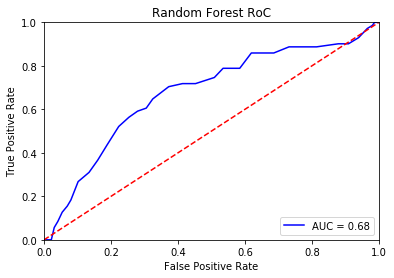

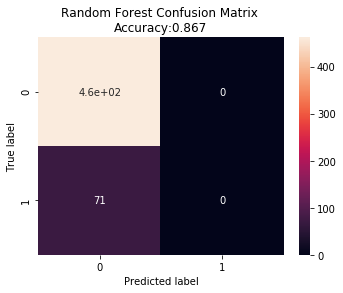

Random Forest  PR Curve: f1=0.000 auc=0.220


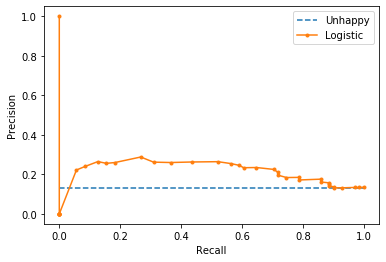

Accuracy: 	 0.8667917448405253
Recall: 	 0.0
Precision: 	 0.0
Specificity: 	 1.0
NPV: 	 0.8667917448405253
F1: 		 0.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
eval(y_oh_test, rf2_prob, rf2_pred, 'Random Forest')

### (5) CatBoost

i. Modeling

In [0]:
# Model params
params_2 = {
    'loss_function': 'MultiClass',
    'eval_metric': 'Accuracy',
    'verbose': 10,
    'random_seed': 24,
    # 'depth':6, 
    'learning_rate':0.0001,
    'use_best_model': True,
    'l2_leaf_reg': 10,
    'bagging_temperature': 3,
    'od_type': "Iter",
    'od_wait': 100
}

cat2 = catboost.CatBoostClassifier(**params_2)
cat2.fit(X_cat_upsample_train, y_cat_upsample_train,
             eval_set = (X_cat_test, y_cat_test),
             cat_features = categorical_features_indices,
             use_best_model = True,
             plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7204461	test: 0.6097561	best: 0.6097561 (0)	total: 85ms	remaining: 1m 24s
10:	learn: 0.7899628	test: 0.7992495	best: 0.8030019 (9)	total: 759ms	remaining: 1m 8s
20:	learn: 0.7736059	test: 0.8123827	best: 0.8142589 (15)	total: 1.31s	remaining: 1m 1s
30:	learn: 0.7747212	test: 0.8123827	best: 0.8142589 (15)	total: 1.85s	remaining: 57.8s
40:	learn: 0.7825279	test: 0.8142589	best: 0.8142589 (15)	total: 2.39s	remaining: 55.9s
50:	learn: 0.7739777	test: 0.8142589	best: 0.8142589 (15)	total: 2.93s	remaining: 54.5s
60:	learn: 0.7784387	test: 0.8142589	best: 0.8142589 (15)	total: 3.46s	remaining: 53.3s
70:	learn: 0.7825279	test: 0.8142589	best: 0.8142589 (15)	total: 4.03s	remaining: 52.8s
80:	learn: 0.7828996	test: 0.8142589	best: 0.8142589 (15)	total: 4.57s	remaining: 51.8s
90:	learn: 0.7832714	test: 0.8142589	best: 0.8142589 (15)	total: 5.12s	remaining: 51.2s
100:	learn: 0.7843866	test: 0.8142589	best: 0.8142589 (15)	total: 5.67s	remaining: 50.4s
110:	learn: 0.7888476	test: 0.8142

ii. Prediction

In [0]:
cat2_pred = cat2.predict(X_cat_test)
cat2_prob = cat2.predict_proba(X_cat_test)

iii. Evaluation

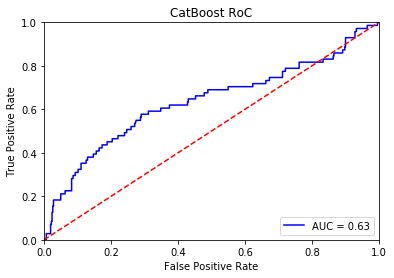

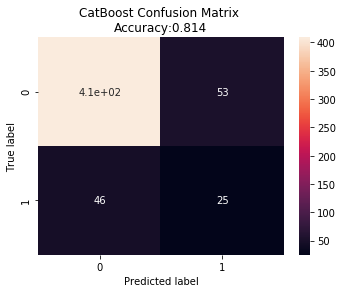

CatBoost  PR Curve: f1=0.336 auc=0.246


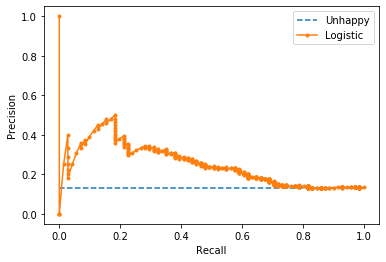

Accuracy: 	 0.8142589118198874
Recall: 	 0.352112676056338
Precision: 	 0.32051282051282054
Specificity: 	 0.8852813852813853
NPV: 	 0.8989010989010989
F1: 		 0.3355704697986578


In [0]:
eval(y_cat_test, cat2_prob, cat2_pred, 'CatBoost')

In [0]:
cat2_feature_score = catboost_feature_importance(cat2, X_cat_test.columns.values)
cat2_feature_score.head(20)

feature_name      score
129        Neuroticism  17.272099
140         LAP_actual  12.439611
131  Conscientiousness   6.847366
142         LAN_actual   6.610563
134              BIS.5   6.352361
128               SWLS   4.382054
145          HA_actual   4.368864
125               hr_1   3.979465
143           N_actual   3.362397
136             BAS_FS   2.041354
126                SBQ   1.888129
138         HAP_actual   1.723568
139           P_actual   1.641805
133          BIS_total   1.589786
48              hr_max   1.458677
151            N_ideal   1.322304
135              BAS_D   1.226864
83         high_hr_30m   1.169653
59           hr_var_3h   0.976839
52             pHR2_3h   0.910599

### (6) Cross Validation

i Scoring criteria

In [0]:
scoring = {
    'precision': 'precision',
    'recall': 'recall',
    'roc_auc':'roc_auc',
    'accuracy': 'accuracy',
    'f1': 'f1',
    'neg_log_loss': 'neg_log_loss'
}

ii. Cross validate Logistic Regression and Random forest

In [0]:
lg_upsample_result = []
rf_upsample_result = []
cat_upsample_result = []
for i in range(4):
  # Split the data: one-hot encoding
  X_oh_train = X_oh.iloc[gkf_modeling[i][0],]
  X_oh_test = X_oh.iloc[gkf_modeling[i][1],]
  y_oh_train = y_oh.iloc[gkf_modeling[i][0],]
  y_oh_test = y_oh.iloc[gkf_modeling[i][1],]

  # Split the data: categorical
  X_cat_train = X_cat.iloc[gkf_modeling[1][0],]
  X_cat_test = X_cat.iloc[gkf_modeling[1][1],]
  y_cat_train = y_cat.iloc[gkf_modeling[1][0],]
  y_cat_test = y_cat.iloc[gkf_modeling[1][1],]
  
  # Upsample and Scale
  X_oh_upsample_train_scaled, y_oh_upsample_train, X_oh_test_scaled = upsample_data_with_oh(X_oh_train, y_oh_train, X_oh_test)
  X_cat_upsample_train, y_cat_upsample_train = upsample_data_with_cat(X_cat_train, y_cat_train)

  # Logistic
  lg = LogisticRegression(max_iter=20000)
  lg.fit(X_oh_upsample_train_scaled, y_oh_upsample_train)
  lg_pred = lg.predict(X_oh_test_scaled)
  lg_res = eval_class(y_oh_test, lg_pred)
  lg_upsample_result.append(lg_res)
  # Random Forest
  rf = RandomForestClassifier(n_estimators=100).fit(X_oh_upsample_train_scaled, y_oh_upsample_train)
  rf_pred = rf.predict(X_oh_test)
  rf_res = eval_class(y_oh_test, rf_pred)
  rf_upsample_result.append(rf_res)
  # CatBoost
  cat = catboost.CatBoostClassifier(**params_2)
  cat.fit(X_cat_upsample_train, y_cat_upsample_train,
             eval_set = (X_cat_test, y_cat_test),
             cat_features = categorical_features_indices,
             use_best_model = True,
             plot=True)
  cat_pred = cat.predict(X_cat_test)
  cat_res = eval_class(y_cat_test, cat_pred)
  cat_upsample_result.append(cat_res)

iii. Post Processing

In [0]:
lg_avg_eval = np.mean(lg_upsample_result, axis=0)
lg_avg_eval = np.append('Logistic', lg_avg_eval)

rf_avg_eval = np.mean(rf_upsample_result, axis=0)
rf_avg_eval = np.append('Random Forest', rf_avg_eval)

cat_avg_eval = np.mean(cat_upsample_result, axis=0)
cat_avg_eval = np.append('CatBoost', cat_avg_eval)

data = [lg_avg_eval, rf_avg_eval, cat_avg_eval]
cv_res = pd.DataFrame(data=data, columns=['model', 'accuracy', 'recall', 'precision', 'specificity', 'npv', 'f1'])

iv. Result

In [0]:
cv_res

model            accuracy  ...                 npv                  f1
0       Logistic  0.6328522470056928  ...  0.8737579743501561  0.2891394519733985
1  Random Forest   0.847250573701074  ...   0.847250573701074                 0.0
2       CatBoost  0.8142589118198874  ...  0.8989010989010989  0.3355704697986578

[3 rows x 7 columns]

### *Could further look into feature importance*

## 7.Under Sample Majority Class

### (1) Undersample for Data with categorical features

In [0]:
def undersample_data_with_cat(X_train, y_train):
  # concatenate our training data back together
  data_cat_to_sample = pd.concat([X_train, y_train], axis=1)

  # separate minority and majority classes
  unhappy_cat = data_cat_to_sample[data_cat_to_sample['valence']==1]
  happy_cat = data_cat_to_sample[data_cat_to_sample['valence']==0]
  # downsample majority
  happy_cat_downsampled = resample(happy_cat,
                                  replace = False, # sample without replacement
                                  n_samples = len(unhappy_cat), # match minority n
                                  random_state = 27) # reproducible results

  # combine minority and downsampled majority
  downsampled_cat = pd.concat([happy_cat_downsampled, unhappy_cat])

  # checking counts
  downsampled_cat['valence'].value_counts()

  # Split train and test
  y_cat_downsample_train = downsampled_cat['valence']
  X_cat_downsample_train = downsampled_cat.drop('valence', axis=1)
  return X_cat_downsample_train, y_cat_downsample_train

X_cat_downsample_train, y_cat_downsample_train = undersample_data_with_cat(X_cat_train, y_cat_train)

### (2) Undersample for Data with one-hot encoding

In [0]:
def downsample_data_with_oh(X_train, y_train, X_test):
  # concatenate our training data back together
  data_oh_to_sample = pd.concat([X_oh_train, y_oh_train], axis=1)


  # separate minority and majority classes
  unhappy_oh = data_oh_to_sample[data_oh_to_sample['valence']==1]
  happy_oh = data_oh_to_sample[data_oh_to_sample['valence']==0]


  # upsample minority
  happy_oh_downsampled = resample(happy_oh,
                            replace=True, # sample with replacement
                            n_samples=len(unhappy_oh), # match number in majority class
                            random_state=27) # reproducible results

  # combine majority and upsampled minority
  downsampled_oh = pd.concat([unhappy_oh, happy_oh_downsampled])

  # check new class counts
  print(downsampled_oh['valence'].value_counts())

  # Split train and test
  y_oh_downsample_train = downsampled_oh['valence']
  X_oh_downsample_train = downsampled_oh.drop('valence', axis=1)

  # Scale for logistic regression
  scaler = preprocessing.StandardScaler().fit(X_oh_downsample_train)
  X_oh_downsample_train_scaled = scaler.transform(X_oh_downsample_train)
  X_oh_test_scaled = scaler.transform(X_test)
  return X_oh_downsample_train_scaled, y_oh_downsample_train, X_oh_test_scaled


X_oh_downsample_train_scaled, y_oh_downsample_train, X_oh_test_scaled = downsample_data_with_oh(X_oh_train, y_oh_train, X_oh_test)


1    264
0    264
Name: valence, dtype: int64


### (3) Logistic Regression

i. Modeling

In [0]:
lg3 = LogisticRegression(max_iter=20000)
lg3.fit(X_oh_downsample_train_scaled, y_oh_downsample_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=20000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

iii. Prediction

In [0]:
lg3_pred = lg3.predict(X_oh_test_scaled)
lg3_prob = lg3.predict_proba(X_oh_test_scaled)

iv. Evaluation

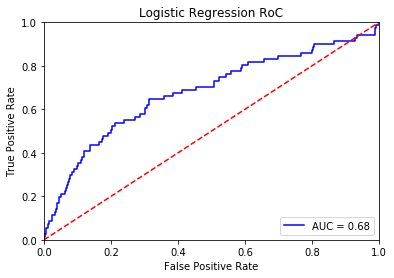

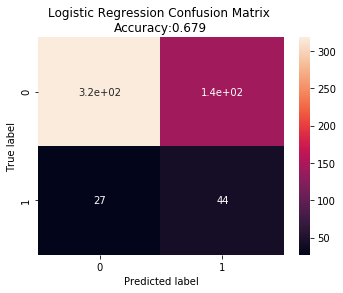

Logistic Regression  PR Curve: f1=0.340 auc=0.287


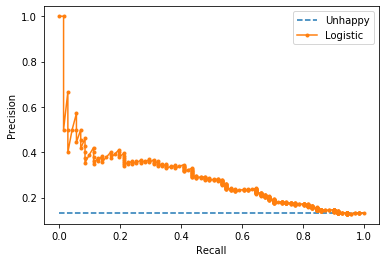

Accuracy: 	 0.6791744840525328
Recall: 	 0.6197183098591549
Precision: 	 0.23404255319148937
Specificity: 	 0.6883116883116883
NPV: 	 0.9217391304347826
F1: 		 0.33976833976833976


In [0]:
eval(y_oh_test, lg3_prob, lg3_pred, 'Logistic Regression')

### (4) Random Forest

i. Modeling

In [0]:
rf3 = RandomForestClassifier(n_estimators=100).fit(X_oh_downsample_train_scaled, y_oh_downsample_train)

ii. Prediction

In [0]:
rf3_pred = rf3.predict(X_oh_test_scaled)
rf3_prob = rf3.predict_proba(X_oh_test_scaled)

iii. Evaluation

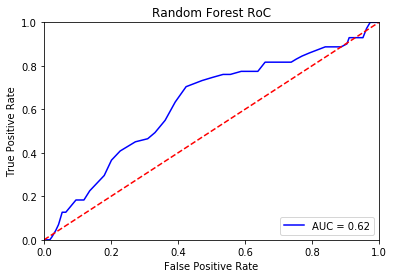

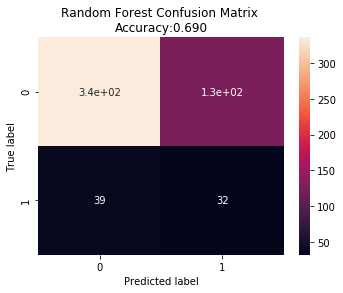

Random Forest  PR Curve: f1=0.279 auc=0.185


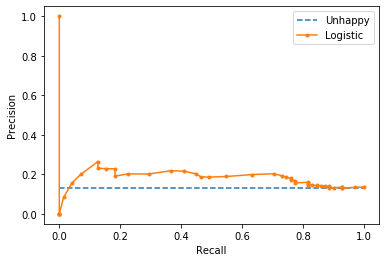

Accuracy: 	 0.6904315196998124
Recall: 	 0.4507042253521127
Precision: 	 0.20253164556962025
Specificity: 	 0.7272727272727273
NPV: 	 0.896
F1: 		 0.2794759825327511


In [0]:
eval(y_oh_test, rf3_prob, rf3_pred, 'Random Forest')

### (5) CatBoost

i. Modeling

In [0]:
# Model params
params_3 = {
    'loss_function': 'MultiClass',
    'eval_metric': 'Accuracy',
    'verbose': 10,
    'random_seed': 24,
    # 'depth':6, 
    'learning_rate':0.0001,
    'use_best_model': True,
    'l2_leaf_reg': 10,
    'bagging_temperature': 3,
    'od_type': "Iter",
    'od_wait': 100
}

cat3 = catboost.CatBoostClassifier(**params_3)
cat3.fit(X_cat_downsample_train, y_cat_downsample_train,
             eval_set = (X_cat_test, y_cat_test),
             cat_features = categorical_features_indices,
             use_best_model = True,
             plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7137255	test: 0.5853659	best: 0.5853659 (0)	total: 98.5ms	remaining: 1m 38s
10:	learn: 0.7529412	test: 0.7485929	best: 0.7804878 (5)	total: 645ms	remaining: 58s
20:	learn: 0.7666667	test: 0.7729831	best: 0.7804878 (5)	total: 1.09s	remaining: 50.7s
30:	learn: 0.7823529	test: 0.7692308	best: 0.7804878 (5)	total: 1.53s	remaining: 47.8s
40:	learn: 0.7960784	test: 0.7804878	best: 0.7804878 (5)	total: 1.95s	remaining: 45.7s
50:	learn: 0.7941176	test: 0.7861163	best: 0.7879925 (49)	total: 2.4s	remaining: 44.8s
60:	learn: 0.8058824	test: 0.7786116	best: 0.7936210 (54)	total: 2.84s	remaining: 43.8s
70:	learn: 0.8000000	test: 0.7823640	best: 0.7936210 (54)	total: 3.28s	remaining: 43s
80:	learn: 0.8098039	test: 0.7673546	best: 0.7936210 (54)	total: 3.71s	remaining: 42.1s
90:	learn: 0.8117647	test: 0.7636023	best: 0.7936210 (54)	total: 4.14s	remaining: 41.3s
100:	learn: 0.8078431	test: 0.7636023	best: 0.7936210 (54)	total: 4.57s	remaining: 40.6s
110:	learn: 0.8039216	test: 0.7729831	be

ii. Prediction

In [0]:
cat3_pred = cat3.predict(X_cat_test)
cat3_prob = cat3.predict_proba(X_cat_test)

iii. Evaluation

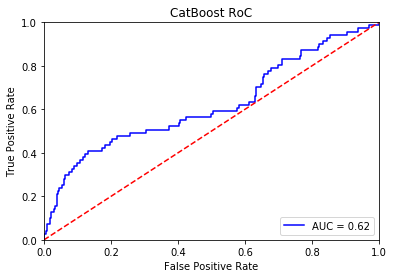

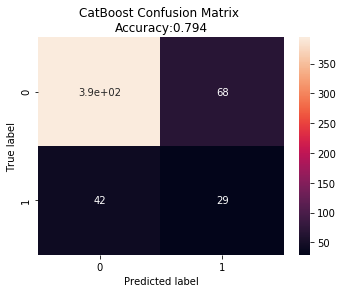

CatBoost  PR Curve: f1=0.345 auc=0.281


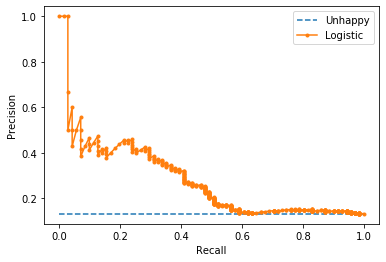

Accuracy: 	 0.7936210131332082
Recall: 	 0.4084507042253521
Precision: 	 0.29896907216494845
Specificity: 	 0.8528138528138528
NPV: 	 0.9036697247706422
F1: 		 0.3452380952380953


In [0]:
eval(y_oh_test, cat3_prob, cat3_pred, 'CatBoost')

In [0]:
cat3_feature_score = catboost_feature_importance(cat3, X_cat_test.columns.values)
cat3_feature_score.head(20)

feature_name      score
140         LAP_actual  13.644426
129        Neuroticism   9.445541
131  Conscientiousness   8.112472
142         LAN_actual   7.779989
127                FTP   3.799581
48              hr_max   3.134556
144         HAN_actual   2.978155
132           NS_total   1.853247
145          HA_actual   1.785462
143           N_actual   1.690526
153           HA_ideal   1.347274
128               SWLS   1.338782
124             hr_0.8   1.243559
87          hr_var_30m   1.184853
139           P_actual   1.137033
52             pHR2_3h   1.106829
136             BAS_FS   1.098100
130       Extraversion   1.086634
98             l_h_10m   0.984542
67            rMSSD_1h   0.983296

### (6) Cross Validation

i. Cross Validation

In [0]:
lg_downsample_result = []
rf_downsample_result = []
cat_downsample_result = []
for i in range(4):
  # Split the data: one-hot encoding
  X_oh_train = X_oh.iloc[gkf_modeling[i][0],]
  X_oh_test = X_oh.iloc[gkf_modeling[i][1],]
  y_oh_train = y_oh.iloc[gkf_modeling[i][0],]
  y_oh_test = y_oh.iloc[gkf_modeling[i][1],]

  # Split the data: categorical
  X_cat_train = X_cat.iloc[gkf_modeling[1][0],]
  X_cat_test = X_cat.iloc[gkf_modeling[1][1],]
  y_cat_train = y_cat.iloc[gkf_modeling[1][0],]
  y_cat_test = y_cat.iloc[gkf_modeling[1][1],]
  
  # Upsample and Scale
  X_oh_downsample_train_scaled, y_oh_downsample_train, X_oh_test_scaled = downsample_data_with_oh(X_oh_train, y_oh_train, X_oh_test)
  X_cat_downsample_train, y_cat_downsample_train = undersample_data_with_cat(X_cat_train, y_cat_train)
  
  # Logistic
  lg = LogisticRegression(max_iter=20000)
  lg.fit(X_oh_downsample_train_scaled, y_oh_downsample_train)
  lg_pred = lg.predict(X_oh_test_scaled)
  lg_res = eval_class(y_oh_test, lg_pred)
  lg_downsample_result.append(lg_res)
  # Random Forest
  rf = RandomForestClassifier(n_estimators=100).fit(X_oh_downsample_train_scaled, y_oh_downsample_train)
  rf_pred = rf.predict(X_oh_test)
  rf_res = eval_class(y_oh_test, rf_pred)
  rf_downsample_result.append(rf_res)
  # CatBoost
  cat = catboost.CatBoostClassifier(**params_2)
  cat.fit(X_cat_downsample_train, y_cat_downsample_train,
             eval_set = (X_cat_test, y_cat_test),
             cat_features = categorical_features_indices,
             use_best_model = True,
             plot=True)
  cat_pred = cat.predict(X_cat_test)
  cat_res = eval_class(y_cat_test, cat_pred)
  cat_downsample_result.append(cat_res)

ii. Post processing

In [0]:
lg_avg_eval = np.mean(lg_downsample_result, axis=0)
lg_avg_eval = np.append('Logistic', lg_avg_eval)

rf_avg_eval = np.mean(rf_downsample_result, axis=0)
rf_avg_eval = np.append('Random Forest', rf_avg_eval)

cat_avg_eval = np.mean(cat_downsample_result, axis=0)
cat_avg_eval = np.append('CatBoost', cat_avg_eval)

data = [lg_avg_eval, rf_avg_eval, cat_avg_eval]
cv_res = pd.DataFrame(data=data, columns=['model', 'accuracy', 'recall', 'precision', 'specificity', 'npv', 'f1'])

iii. Result

In [0]:
cv_res

model            accuracy  ...                 npv                   f1
0       Logistic  0.5958154819754405  ...  0.8792899182451954  0.29217697451945246
1  Random Forest  0.5771514299575613  ...  0.8352948395494809  0.15384541877459246
2       CatBoost  0.7936210131332082  ...  0.9036697247706422   0.3452380952380953

[3 rows x 7 columns]

## 8.Generate Synthetic Samples (SMOTE)

### (1) Generate New Samples for Data with categorical features

In [0]:
sm = SMOTE(random_state=27, ratio=1.0)
X_oh_smo_train, y_oh_smo_train = sm.fit_sample(X_oh_train, y_oh_train)

# SMOTE could not handle categorical data well, let's only usng one-hot first
# from imblearn.over_sampling import SMOTENC
# sm_nc = SMOTENC(categorical_features=categorical_features_indices, random_state=27)
# X_cat_smo_train, y_cat_smo_train = sm_nc.fit_sample(X_cat_train, y_cat_train)

scaler = preprocessing.StandardScaler().fit(X_oh_smo_train)
X_oh_smo_train_scaled = scaler.transform(X_oh_smo_train)
X_oh_test_scaled = scaler.transform(X_oh_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


### (2) Logistic Regression

i. Modeling

In [0]:
lg4 = LogisticRegression(max_iter=20000)
lg4.fit(X_oh_smo_train_scaled, y_oh_smo_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=20000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

iii. Prediction

In [0]:
lg4_pred = lg4.predict(X_oh_test_scaled)
lg4_prob = lg4.predict_proba(X_oh_test_scaled)

iv. Evaluation

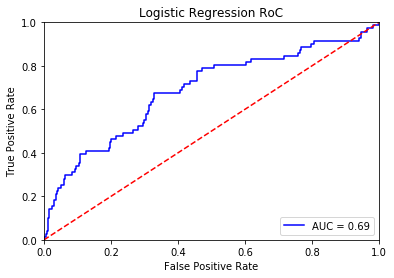

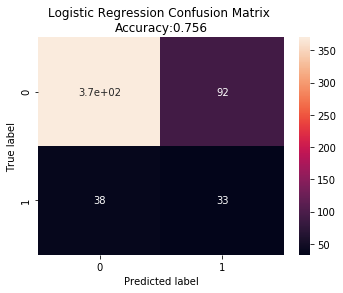

Logistic Regression  PR Curve: f1=0.337 auc=0.297


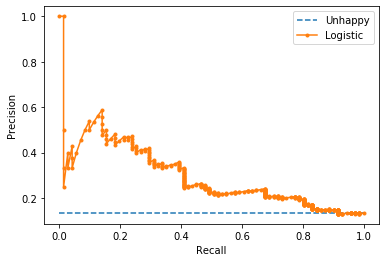

Accuracy: 	 0.7560975609756098
Recall: 	 0.4647887323943662
Precision: 	 0.264
Specificity: 	 0.8008658008658008
NPV: 	 0.9068627450980392
F1: 		 0.336734693877551


In [0]:
eval(y_oh_test, lg4_prob, lg4_pred, 'Logistic Regression')

### (3) Random Forest

i. Modeling

In [0]:
rf4 = RandomForestClassifier(n_estimators=100).fit(X_oh_smo_train_scaled, y_oh_smo_train)

ii. Prediction

In [0]:
rf4_pred = rf4.predict(X_oh_test_scaled)
rf4_prob = rf4.predict_proba(X_oh_test_scaled)

iii. Evaluation

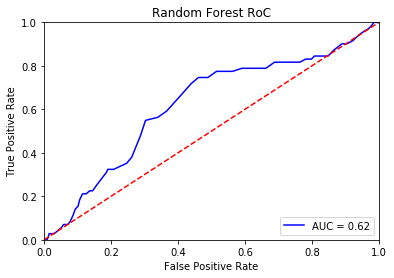

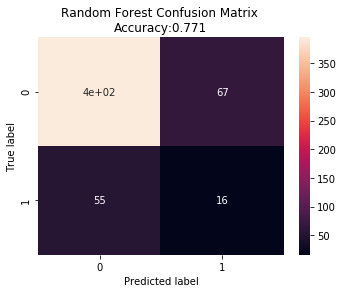

Random Forest  PR Curve: f1=0.208 auc=0.178


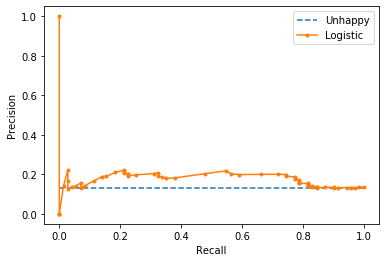

Accuracy: 	 0.7711069418386491
Recall: 	 0.22535211267605634
Precision: 	 0.1927710843373494
Specificity: 	 0.854978354978355
NPV: 	 0.8777777777777778
F1: 		 0.2077922077922078


In [0]:
eval(y_oh_test, rf4_prob, rf4_pred, 'Random Forest')

### (4) CatBoost

i. Modeling

In [0]:
# Model params
params_4 = {
    'loss_function': 'MultiClass',
    'eval_metric': 'Accuracy',
    'verbose': 10,
    'random_seed': 24,
    # 'depth':6, 
    'learning_rate':0.0001,
    'use_best_model': True,
    'l2_leaf_reg': 10,
    'bagging_temperature': 3,
    'od_type': "Iter",
    'od_wait': 100
}

cat4 = catboost.CatBoostClassifier(**params_4)
cat4.fit(X_oh_smo_train_scaled, y_oh_smo_train,
             eval_set = (X_oh_test_scaled, y_oh_test),
             use_best_model = True,
             plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7576208	test: 0.6510319	best: 0.6510319 (0)	total: 76.9ms	remaining: 1m 16s
10:	learn: 0.8438662	test: 0.7354597	best: 0.7786116 (6)	total: 629ms	remaining: 56.5s
20:	learn: 0.8446097	test: 0.7467167	best: 0.7786116 (6)	total: 1.06s	remaining: 49.5s
30:	learn: 0.8434944	test: 0.7560976	best: 0.7786116 (6)	total: 1.5s	remaining: 47s
40:	learn: 0.8468401	test: 0.7917448	best: 0.7954972 (39)	total: 1.94s	remaining: 45.4s
50:	learn: 0.8449814	test: 0.7898687	best: 0.7954972 (39)	total: 2.38s	remaining: 44.2s
60:	learn: 0.8479554	test: 0.8067542	best: 0.8067542 (60)	total: 2.81s	remaining: 43.2s
70:	learn: 0.8501859	test: 0.8067542	best: 0.8161351 (61)	total: 3.25s	remaining: 42.5s
80:	learn: 0.8509294	test: 0.8123827	best: 0.8180113 (74)	total: 3.68s	remaining: 41.8s
90:	learn: 0.8509294	test: 0.7729831	best: 0.8180113 (74)	total: 4.13s	remaining: 41.3s
100:	learn: 0.8460967	test: 0.7748593	best: 0.8180113 (74)	total: 4.56s	remaining: 40.6s
110:	learn: 0.8479554	test: 0.7748593

ii. Prediction

In [0]:
cat4_pred = cat4.predict(X_oh_test_scaled)
cat4_prob = cat4.predict_proba(X_oh_test_scaled)

iii. Evaluation

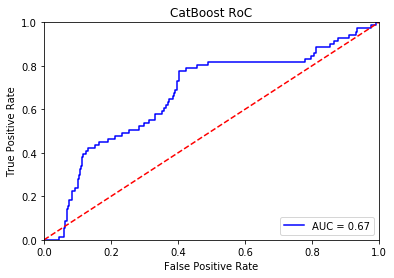

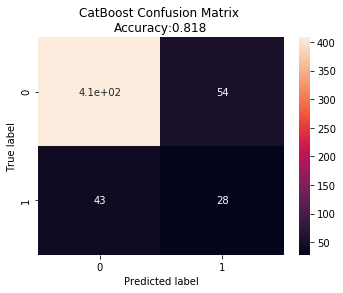

CatBoost  PR Curve: f1=0.366 auc=0.216


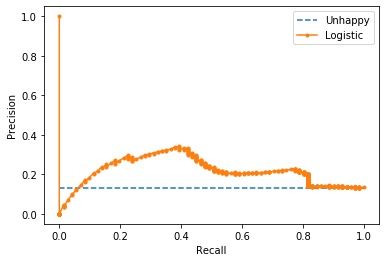

Accuracy: 	 0.8180112570356473
Recall: 	 0.39436619718309857
Precision: 	 0.34146341463414637
Specificity: 	 0.8831168831168831
NPV: 	 0.9046563192904656
F1: 		 0.36601307189542487


In [0]:
eval(y_oh_test, cat4_prob, cat4_pred, 'CatBoost')

### (5) Cross Validation

i. Cross Validation

In [0]:
lg_smote_result = []
rf_smote_result = []
cat_smote_result = []
for i in range(4):
  # Split the data: one-hot encoding
  X_oh_train = X_oh.iloc[gkf_modeling[i][0],]
  X_oh_test = X_oh.iloc[gkf_modeling[i][1],]
  y_oh_train = y_oh.iloc[gkf_modeling[i][0],]
  y_oh_test = y_oh.iloc[gkf_modeling[i][1],]
  
  # Upsample and Scale

  sm = SMOTE(random_state=27, ratio=1.0)
  X_oh_smo_train, y_oh_smo_train = sm.fit_sample(X_oh_train, y_oh_train)

  scaler = preprocessing.StandardScaler().fit(X_oh_smo_train)
  X_oh_smo_train_scaled = scaler.transform(X_oh_smo_train)
  X_oh_test_scaled = scaler.transform(X_oh_test)

  # Logistic
  lg = LogisticRegression(max_iter=20000)
  lg.fit(X_oh_smo_train_scaled, y_oh_smo_train)
  lg_pred = lg.predict(X_oh_test_scaled)
  lg_res = eval_class(y_oh_test, lg_pred)
  lg_smote_result.append(lg_res)
  # Random Forest
  rf = RandomForestClassifier(n_estimators=100).fit(X_oh_smo_train_scaled, y_oh_smo_train)
  rf_pred = rf.predict(X_oh_test_scaled)
  rf_res = eval_class(y_oh_test, rf_pred)
  rf_smote_result.append(rf_res)
  # CatBoost
  cat = catboost.CatBoostClassifier(**params_2)
  cat.fit(X_oh_smo_train, y_oh_smo_train,
             eval_set = (X_oh_test, y_oh_test),
             use_best_model = True,
             plot=True)
  cat_pred = cat.predict(X_oh_test)
  cat_res = eval_class(y_oh_test, cat_pred)
  cat_smote_result.append(cat_res)

ii. Post processing

In [0]:
lg_avg_eval = np.mean(lg_smote_result, axis=0)
lg_avg_eval = np.append('Logistic', lg_avg_eval)

rf_avg_eval = np.mean(rf_smote_result, axis=0)
rf_avg_eval = np.append('Random Forest', rf_avg_eval)

cat_avg_eval = np.mean(cat_smote_result, axis=0)
cat_avg_eval = np.append('CatBoost', cat_avg_eval)

data = [lg_avg_eval, rf_avg_eval, cat_avg_eval]
cv_res = pd.DataFrame(data=data, columns=['model', 'accuracy', 'recall', 'precision', 'specificity', 'npv', 'f1'])

iii. Result

In [0]:
cv_res

model            accuracy  ...                 npv                  f1
0       Logistic  0.6422712271321768  ...  0.8680086017861752   0.276520544115082
1  Random Forest  0.7667330881155786  ...  0.8541696036338152  0.1478471052269333
2       CatBoost  0.7473147839314311  ...  0.8646621785098871  0.2475910452272776

[3 rows x 7 columns]

## 9.Conclusion

1. Over Sample Minority + CatBoost gives best performance:

* Recall: 	 0.5714285714285714
* Precision: 	 0.4195804195804196
* AUC: 0.71
2. The top 3 important features are:
* Ethnicity	16.765079
* LAP_actual	11.967100
* Neuroticism	8.503524
3. Under sample majority in helps logistic regression and random forest improve accuracy.